🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, I will be going through an example machine learning project with the goal of predicting the sale price of bulldozers

1. Problem Definition

    How well can I predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozer have been sold for?

2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozer competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

-   Train.csv is the training set, which contains data through the end of 2011.
-    Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
-   Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note**: The goal for most regression evaluation metrics is to minimize the error. For example, the goal for this project will be to build a machine learning model which minimises RMSLE.

4. Features

The key fields are in train.csv are:

    SalesID: the uniue identifier of the sale
    MachineID: the unique identifier of a machine.  A machine can be sold multiple times
    saleprice: what the machine sold for at auction (only provided in train.csv)
    saledate: the date of the sale

Kaggle also provided a Data Dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# To see how fast the model executes
import time

In [5]:
# Import training and validation set
# To get rif of the warning, set low_memory=False (Dont minimize the RAM space, just use it all)
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)

In [6]:
# Check on the information type on the project
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [7]:
# Check if there is any null values
df.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

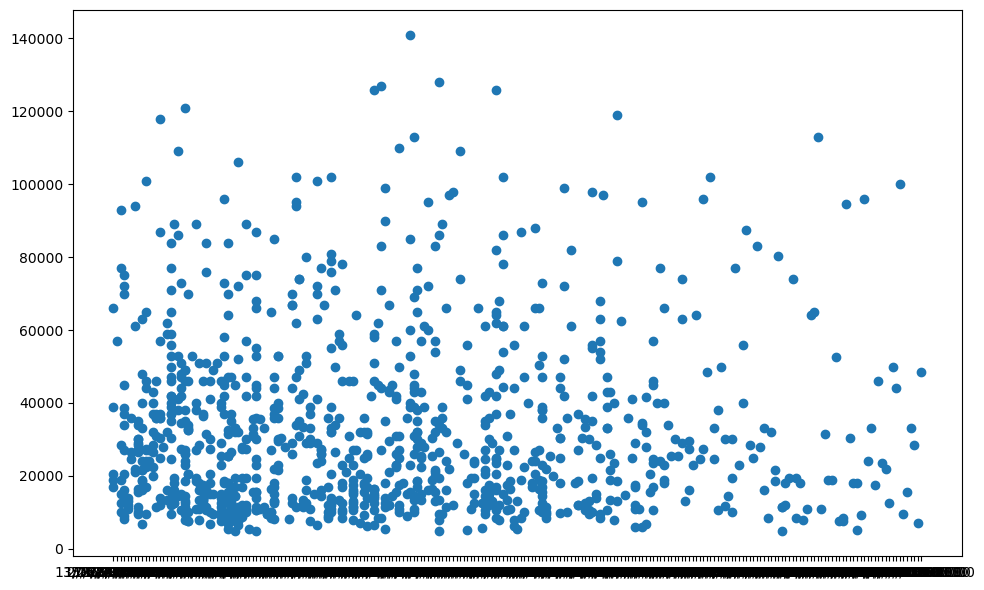

In [9]:
# To visualize the first 1000 sold bulldozer against the sale price just to get some information about the data

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])
plt.tight_layout()
plt.show()

In [12]:
# The Python Object contains string, will need to properly encode in dates later as this is a time-series object
df.saledate.dtype

dtype('O')

<Axes: ylabel='Frequency'>

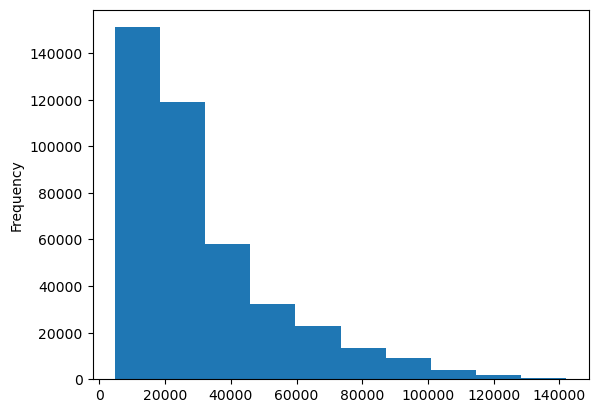

In [11]:
df.SalePrice.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the 'parse_dates' parameter

Parsing dates with NumPy typically involves converting string representations of dates and times into NumPy's datetime64 data type. This enables efficient date and time calculations within NumPy arrays.


In [14]:
# Import data again and parse the dates

df = pd.read_csv("data/TrainAndValid.csv",
                low_memory=False,
                parse_dates=["saledate"])
df[:1000]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1142566,33000.0,1069733,5428,121,3.0,2005,3759.0,Medium,2009-07-16,...,None or Unspecified,None or Unspecified,Hydraulic,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
996,1142567,62000.0,531918,23162,121,3.0,2005,1290.0,Medium,2007-06-14,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
997,1142568,8000.0,1064508,17472,121,3.0,1998,1865.0,Medium,2005-09-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
998,1142577,16000.0,1046210,13391,121,3.0,2004,851.0,High,2005-07-28,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [16]:
# Numpy way of saying datetime64[ns]

df.saledate.dtype

dtype('<M8[ns]')

In [17]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

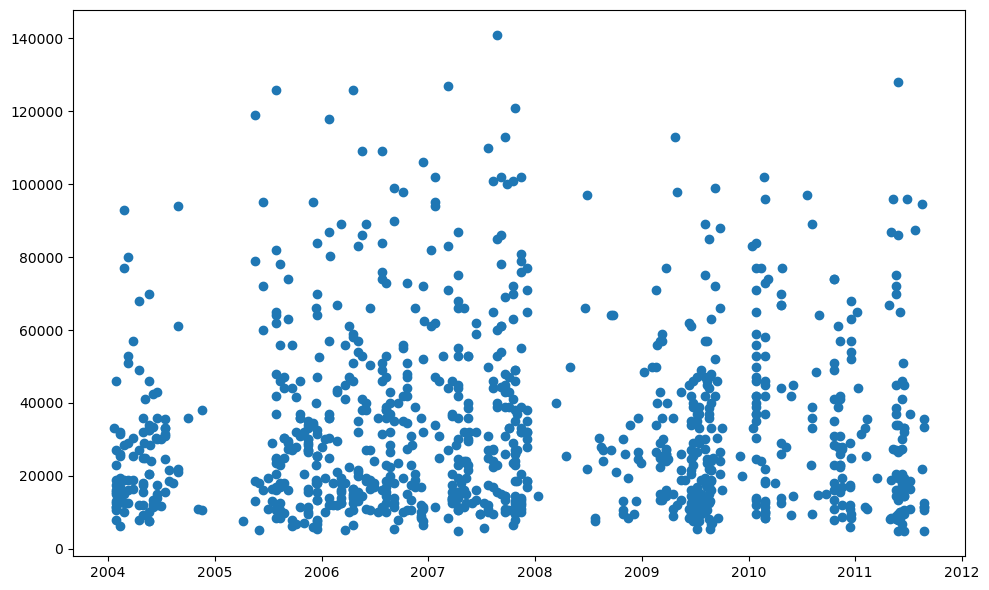

In [19]:
# Now properly plot the scatter plot to see the difference
# Now the scatter plot is properly distributed by the year

fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])
plt.tight_layout()
plt.show()

In [23]:
# To see every column and not being truncated, transpose the axis
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [25]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort Dataframe by saledate

When working with time series data, it's a good idea to sort it by date

In [29]:
# Sort dataframe in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
67974    1989-01-31
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original Dataframe

We make a copy of the original dataframe so when we manipualte the copy, we still have the original data

In [30]:
# Make a copy
df_tmp = df.copy()

In [31]:
df_tmp.saledate.head(20)

205615   1989-01-17
67974    1989-01-31
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Add datetime parameters for "saledate" column - To be done for every timeseries data

In [34]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [41]:
# Since the proper sales date column has been created, the original saledate column can be dropped

df_tmp.drop("saledate",axis=1, inplace=True)

In [42]:
# Check the values of different columns

df_tmp.state.value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

## 5. Modelling

We've done enough EDA (we could always do more), let's start to do some model-drive EDA

In [50]:
# Need to fill missing values as unable to do train_test_split

## Fill missing values

### Fill numerical missing values first

In [53]:
# Check which columns are numeric

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [54]:
df_tmp.ModelID

205615     8434
67974      3819
274835    10150
141296     4139
212552     8591
          ...  
411927    17244
409783     4605
409202     4701
411649     9579
409203     4701
Name: ModelID, Length: 412698, dtype: int64

In [59]:
# Check for which numeric columns have null values

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [60]:
# Fill numeric rows with mediian

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            # To tell us that this particular sample had a missing sample
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            # Median is robust than mean (less sensitive to outliers)
            df_tmp[label] = content.fillna(content.median())

In [64]:
# Demonstrate how median is more robust than mean

hundreds = np.full((1000,),100)
hundreds_billion = np.append(hundreds, 1000000000)

np.mean(hundreds), np.mean(hundreds_billion)

(np.float64(100.0), np.float64(999100.8991008991))

In [65]:
np.median(hundreds), np.median(hundreds_billion)

(np.float64(100.0), np.float64(100.0))

In [67]:
# Check again if there is any null numeric values

for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [69]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

In [70]:
# This shows that we filled us 20136 missing data samples with the median

In [71]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

## Filling and turning categorical variables into numbers 

In [75]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
            print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [83]:
# Turn categorical variables into numbers and fill missing

for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column to indicate whether sample has missing values
        df_tmp[label + "_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add + 1
        # Pandas will automatically assign missing values with -1, we add + 1 so that it is 0
        df_tmp[label] = pd.Categorical(content).codes + 1

In [87]:
pd.Categorical(df_tmp["state"]).codes

array([44,  9,  9, ...,  5,  5,  5], shape=(412698,), dtype=int8)

In [96]:
# To demonstrate if we do not +1
pd.Categorical(df["UsageBand"]).codes

array([-1, -1, -1, ..., -1, -1, -1], shape=(412698,), dtype=int8)

In [100]:
# To check for missing values again

for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [97]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int32(5), int64(5), int8(40)
memory usage: 73.2 MB


In [98]:
df_tmp.head().T

,205615,67974,274835,141296,212552
SalesID,1646770,1344379,1821514,1505138,1671174
SalePrice,9500.0,70000.0,14000.0,50000.0,16000.0
MachineID,1126363,1374638,1194089,1473654,1327630
ModelID,8434,3819,10150,4139,8591
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,True,False,True
Blade_Type_is_missing,False,True,True,False,True
Travel_Controls_is_missing,False,True,True,False,True
Differential_Type_is_missing,True,False,False,True,False


Now that all of the data is numerica as well as our dataframe has no missing values, we should be able to build a machine learning model

In [106]:
%%time

# Instantiate a machine learning model

# Set random seed
np.random.seed(42)

# Instantiate the model
model = RandomForestRegressor(random_state=42,
                              n_jobs=-1)

# Creating X and y
X = df_tmp.drop("SalePrice", axis=1)
y = df_tmp.SalePrice

# Splitting it to 80-10-10 
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.1,
                                                            random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=10/90,
                                                  random_state=42)

# Fitting the model to the data
model.fit(X_train, y_train)

CPU times: user 11min 6s, sys: 7.44 s, total: 11min 13s
Wall time: 1min 38s


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [108]:
# Scoring the model
model.score(X_test,y_test)

0.905389939291585

## Question, is the metric above reliable?